In [1]:
# 파이썬 2와 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글 출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. 큰 그림 보기

#### 데이터셋
* 데이터셋 : 캘리포니아 인구조사 데이터  
* 특성 : 블록 그룹(block group)마다 인구(population), 중간 소득(median incom), 중간 주택 가격(median housing price) 등  
* 특성 설명
  * 블록 그룹 : 미국 인구조사국에서 샘플 데이터를 발표하는 데 사용하는 최소한의 지리적 단위(간단히 '구역'이라고 부를 예정)
    * 하나의 블록 그룹은 보통 600 ~ 3,000명의 인구를 나타낸다.
    
#### 목표
다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격 예측

## 1.1. 문제 정의
### 1.1.1. 상사에게 해야할 질문
1. 비즈니스의 목적이 정확히 무엇인가요?
   * 회사는 이 모델을 어떻게 사용해 이익을 얻으려고 할 것인지 
   * 즉 문제를 어떻게 구성할지, 어떤 알고리즘을 선택할지, 모델 평가에 어떤 성능 지표를 사용할지, 모델 튜닝을 위해 얼마나 노력을 투여할지 결정하는 아주 중요한 질문
#### Answer
    * 결과의 사용용도 : 구역의 중간 주택 가격의 예측치가 여러 가지 다른 신호(signal, 머신러닝 시스템에 주입하는 정보를 종종 신호라고 부름)와 함께 다른 머신러닝 시스템의 입력으로 사용
    * 뒤따르는 시스템이 해당 지역에 투자할 가치가 있는지 결정한다.
    * 이 결정이 수익에 직결되기 때문에 올바르게 예측하는 것이 매우 중요
    * 부동산 투자를 위한 머신러닝 파이프라인
    <img src='../../dsschool_img/machine_learning_pipeline.png'>
 
> **파이프라인**  
* 데이터 파이프라인(pipeline) : 데이터 처리 컴포넌트(component)들이 연속되어 있는 것
* 머신러닝 시스템은 데이터를 조작, 변환하는 일이 많아 파이프라인을 사용하는 일이 매우 흔하다.
* 보통 component들은 비동기적으로 동작한다.  
각 component는 결과를 다른 데이터 저장소로 보낸다.  
그러면 일정 시간 후 다음 component가 그 데이터를 추출해 자신의 출력 결과를 만드는 식이다.
* 각 component는 완전히 독립적이다.  
즉 component 사이의 인터페이스는 데이터 저장소 뿐이다.
* 한편 모니터링이 적절히 되지 않으면 고장 난 component를 한동안 모를 수 있고 데이터가 만들어진지 오래 되면 전체 시스템의 성능이 떨어진다.

2. 현재 솔루션은 어떻게 구성되어 있나요?
   * 문제 해결 방법에 대한 정보 획득, 참고 성능으로 사용 가능
#### Answer
    * 현재는 구역 주택 가격을 전문가가 수동으로 추정하는 중
    * 한 팀이 구역에 관한 최신 정보를 모으고 있고, 중간 주택 가격을 얻을 수 없을 때는 복잡한 규칙을 사용하여 추정 중
        * 이는 비용과 시간이 많이 들고 추정 결과도 썩 좋지 않다 

### 1.1.2. 모델 문제 정의
* 지도 학습? 비지도 학습? 강화 학습?
    * 레이블된 훈련 샘플(각 샘플이 기대 출력값, 즉 구역의 중간 주택 가격을 가지고 있다.)이 있기 때문에 전형적인 지도 학습
* 분류? 회귀? 다른 작업?
    * 값을 예측하므로 전형적인 회귀 문제
    * 좀 더 구체적으로 특성이 여러 개(구역의 인구, 중간 소득 층)이므로 다변량 회귀(multivariate regression) 문제
* 배치 학습? 온라인 학습?
    * 이 시스템에 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고, 데이터가 메모리에 들어갈 만큼 충분히 작으므로 일반적인 배치 학습
    > 데이터가 매우 크면 맵리듀스(MapReduce)를 사용해 배치 학습을 여러 서버로 분할하거나, 대신 온라인 학습 기법을 사용할 수 있다.

## 1.2. 성능 측정 지표 
#### 평균 제곱근 오차(RMSE, Root Mean Square Error)
* 회귀 문제의 전형적인 성능 지표
* 오차가 커질수록 이 값은 더욱 커져 예측에 얼마나 많은 오류가 있는지 가늠하게 해준다.
$$ \mbox{RMSE}(\mathbf X,h) = \sqrt{\frac{1}{m}∑^m_{i=1}(h(\mathbf x^i) - y^i)^2)} $$
> **표기법**
  * $m$ : RMSE를 측정할 데이터셋의 샘플 수
       * ex)  
       2,000개 구역의 검증 세트에 대해 RMSE를 평가한다면 m = 2,000
  * $\mathbf x^i$ : i번째 샘플(레이블을 제외한)의 전체 특성값의 벡터
  * $y^i$ : 해당 레이블(해당 샘플의 기대 출력값)
  * ex)  
  데이터셋의 첫 번째 구역이 경도 -118.29˚, 위도 33.91˚의 위치, 중간 소득 \\$38,372, 주민 1,416명, 중간 주택 가격 \\$156,400이라면(다른 특성은 고려하지 않음)  
    * $\mathbf x^1 =  \begin{bmatrix}
              -118.29\\
              33.91\\
              1,416\\
              38,372
              \end{bmatrix} $
    * $y^1$ = 156,400
  * $X$ : 모든 특성값(레이블은 제외)을 포함하는 행렬
    * $\mathbf X = \begin{bmatrix}
        (\mathbf x^1)^T\\
        (\mathbf x^2)^T\\
        \dots\\
        (\mathbf x^{2000})^T
        \end{bmatrix} = \begin{bmatrix}
        -118.29 & 33.91 & 1,416 & 38.372\\
        \dots & \dots & \dots & \dots
        \end{bmatrix}$
    * $i$번째 행 = $(\mathbf x^i)^T$
  * $h$(가설, hypothesis) : 시스템 예측 함수
    * 시스템의 하나의 샘플 특성 벡터 $\mathbf x^i$를 받으면 그 샘플에 대한 예측값 $\hat y^i = h(\mathbf x^i)$를 출력한다.
  * $\mbox{RMSE}(\mathbf X, h$) : 가설 $h$를 사용하여 일련의 샘플을 평가하는 비용 함수
  * **사용할 표기법**
    * 스칼라 값 or 함수 : 이탤릭체 소문자 $m, y^i, h$ 등
    * 벡터 : 굵은 소문자 $\mathbf x^i$
    * 행렬 : 굵은 대문자 $\mathbf X$

#### 평균 절대 오차 (MAE, Mean Absolute Error)(평균 절대 편차, Mean Absolute Deviation)
* 또 다른 성능 지표 
* 이상치가 많을 때 고려해 볼 수 있음
$$ \mbox{MAE}(\mathbf X, h) = \frac{1}{m}\sum^m_{i=1}|h(\mathbf x^i)-y^i|$$


#### 거리 측정 방법
* RMSE와 MAE 모두 예측값의 벡터와 타깃값 벡터 사이의 거리를 재는 방법이다.
* 거리 측정 방법(또는 노름(norm))
    * **유클리디안 노름(Euclidian norm)** : 제곱항을 합한 것의 제곱근(RMSE) 계산
        * 우리가 친숙한 거리 개념
        * **$ℓ_2$ 노름**이라고도 부른다.
        * $||·||_2$ (또는 $||·||$)로 표시
    * **맨해튼 노름(Manhattan norm)** : 절댓값의 합을 계산
        * **$ℓ_1$ 노름**이라고도 부른다.
        * $||·||_1$로 표시
* 일반적인 원소 $n$개인 벡터 $\mathbf v$의 $ℓ_k$ 노름
$$ ||\mathbf v||_k = (|v_0|^k + |v_1|^k + ... + |v_n|^k)^{\frac{1}{k}} $$
    * $ℓ_0$ :  단순히 벡터에 있는 0이 아닌 원소의 수
    * $ℓ_∞$ : 벡터에서 가장 큰 절댓값
    * 노름의 지수가 클수록 큰 값의 원소에 치우치며, 작은 값은 무시된다.
    * 그래서 RMSE가 MAE보다 조금 더 이상치에 민감하다.
    * 하지만 이상치가 매우 드물면 RMSE가 잘 맞아 일반적으로 널리 사용된다.

## 1.3. 가정 검사
* 지금까지 만든 가정을 동료들과 나열하고 검사해보는 것이 좋다.
* ex)  
시스템이 출력한 구역의 가격이 다음 머신러닝 시스템의 입력으로 들어갈 줄 알았는데 이 값 대신 '저렴', '보통', '고가' 같은 카테고리로 바꿔 사용할 수도 있기 때문이다. 
    * 그러면 정확한 가격이 아닌 올바른 카테고리를 구하는 시스템이 필요
    * 이 문제는 회귀가 아니라 분류 작업이 된다.

# 2. 데이터 가져오기
## 2.1. 작업환경 만들기
* 머신러닝 코드와 데이터셋을 저장할 작업 디렉토리 만들기
    * 터미널을 열고 다음 명령 실행(\$ 프롬프트 다음이 명령)  
    `export ML_PATH="$HOME/ml"`  
    `mkdir -p \$ML_PATH`
* 독립적인 환경 만들기  
    `pip install --user --upgrade virtualenv`  
    `cd $ML_PATH`  
    `virtualenv env` (시스템에 설치된 패키지를 사용하고 싶다면 `-system-site-packages` 옵션 추가)  
    `source env/bin/activate`
* 파이썬 패키지 설치
    * 아나콘다 써두 됨(권장)
        * 아나콘다 패키징 도구 : `conda`
    * pip로 필요한 패키지와 의존성으로 연결된 다른 패키지 모두 설치 및 확인  
    `pip3 install --upgrade jupyter matplotlib numpy pandas scipy scikit-learn`  
    `python3 -c "import jupyter, matplotlib, numpy, pandas, scipy, sklearn"`  
* 주피터 노트북 실행  
    `jupyter notebook`
    * default port : 8888
    * web : http://localhost:8888/ (보통 서버가 시작될 때 자동으로 브라우저 연결해줌)
    * 현재 작업공간 디렉토리가 보일 것임
        * virtualenv 설정 그대로 따라했다면 env 디렉토리만 있다.

## 2.2. 데이터 다운로드 및 로드
* housing.csv를 압축한 housing.tgz 파일 내려받기

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # 작업 공간에 datasets/housing 디렉토리 만들기
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # housing.tgz 파일 내려받기
    urllib.request.urlretrieve(housing_url, tgz_path)
    # 압축풀어 housing.csv 파일 만들기
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

#### 데이터 로드

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## 2.3. 데이터 구조 훑기

#### 데이터프레임 확인하기

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### 데이터프레임 구조 살펴보기

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> * 20,640개 샘플
* total_bedrooms 특성(필드) : 20,433개만 null값이 아님
* ocean_proximity 특성 : 어떤 파이썬 객체도 될 수 있지만, csv에서 읽어 들였기 때문에 텍스트 특성일 것임
    * 열 값이 반복되기 때문에 범주형(categorical) 데이터로 보임
    
#### 범주형 특성 카테고리 확인

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### 숫자형 특성 통계량 확인

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


> * null값은 제외된다.
* total_bedrooms 특성의 count가 20,640이 아닌 20,433이다.

#### 데이터 형태 히스토그램으로 확인하기
* 수평축 : 주어진 값의 범위
* 수직축 : 범위에 속한 샘플 수
* 특성마다 따로 히스토그램을 그릴 수도 있고, 전체 데이터셋에 `hist()` 메서드를 호출하여 모든 숫자형 특성에 대한 히스토그램도 출력할 수 있다.

> **NOTE**  
* `hist()`
    * 맷플롯립을 사용하고 결국 그래프를 그리기 위해 사용자 컴퓨터의 그래픽 백엔드를 필요로 한다.  
    * 그 벡엔드 지정을 주피터 노트북 매직 명령 `%matplotlib inline`을 사용하면 편하다. 이 명령은 주피터 자체의 벡엔드를 사용하도록 설정한다.  
    * IPython kernel 4.4.0부터는 매직 명령 사용하지 않아도 matplotlib 1.5 이상에서 자동으로 주피터 자체 벡엔드로 설정된다.
* `show()`
    * 주피터는 셀 실행 시 자동으로 그래프를 그려주기 때문에, 주피터노트북에서 그래프를 그릴 때 `show()` 메서드 호출은 선택사항이다.

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


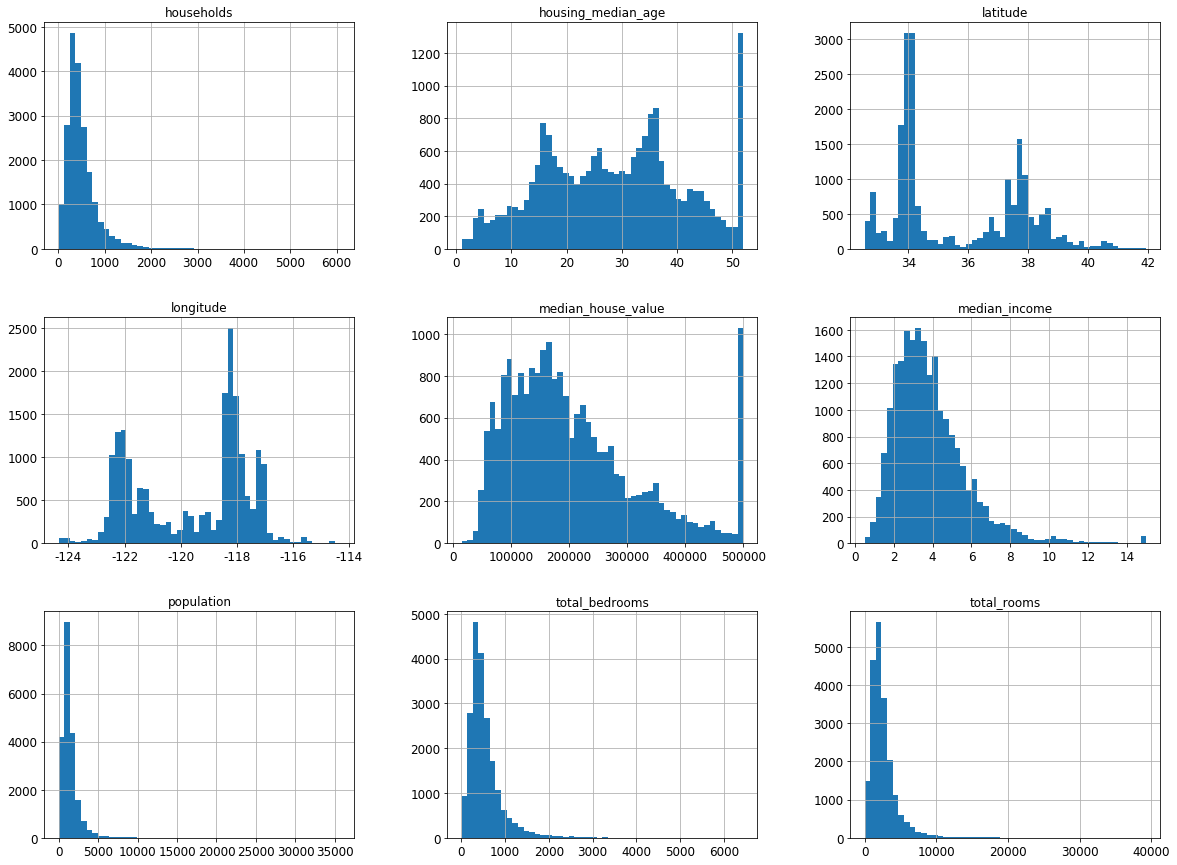

In [8]:
# 주피터 노트북의 매직 명령
%matplotlib inline 
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

> * median income(중간 소득) 특성
    * US 달러로 표현되어 있지 않다.
    * 데이터 취합 팀에 확인해보니 스케일을 조정하고, 상한 15(실제 15.001), 하한 0.5(실제 0.4999)가 되도록 만들었다고 한다.
    * 머신러닝에서는 전처리된 데이터를 다루는 경우가 흔하다.  
    이게 문제가 되지는 않지만 데이터가 어떻게 계산된 것인지 반드시 이해하고 있어야 한다.
* housing median age(중간 주택 연도), median house value(중간 주택 가격)
  * 역시 최댓값, 최솟값을 한정했다.  
  histogram의 맨 오른쪽 그래프가 심하게 높아지면서 끝나는 것으로 보아 한정되었음을 짐작할 수 있다.
  * 중간 주택 가격은 타깃 속성(레이블)으로 사용되기 때문에 심각한 문제가 될 수 있다.  
  가격이 한곗값을 넘어가지 않도록 머신러닝 알고리즘이 학습될지도 모른다.
  * 문제될지 여부는 클라이언트 팀(이 시스템의 출력을 사용할 팀)과 함께 검토하는 것이 좋다.
  * 만약 \\$500,000를 넘어가도 정확한 예측값이 필요하다면 선택사항
      1. 한곗값 밖의 구역에 대한 정확한 레이블을 구한다.
      2. 훈련 세트에서 이런 구역 제거
           * \\$500,000가 넘는 값에 대한 예측은 평가 결과가 매우 나쁠 것이므로 테스트 세트에서도 제거한다.
* 특성들의 스케일이 서로 많이 다르다.
* 많은 histogram이 꼬리가 두껍다. 
  * 가운데에서 왼쪽보다 오른쪽으로 더 멀리 뻗어있다.
  * 이런 분포는 일부 머신러닝 알고리즘에서 패턴을 찾기 어렵게 만든다.

## 2.4. 테스트 세트 만들기
* **데이터 스누핑(data snooping) 편향** : 만약 테스트 세트를 들여다 봤을 때 겉으로 들어난 패턴에 속아 특정 머신러닝 모델을 선택할 수 있다.  
테스트 세트로 일반화 오차를 추정하면 매우 낙관적인 추정이 되며 시스템을 론칭했을 때 기대한 성능이 나오지 않는 것
* 테스트 세트는 보통 무작위로 데이터셋의 20% 정도 떼어낸다.

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


> 위 코드는 프로그램을 다시 실행하면 다른 테스트 세트가 생성된다.  
여러 번 계속하면 전체 데이터셋을 보는 셈이므로 이런 상황은 피해야 한다.

#### 해결책
1. 처음 실행에서 테스트 세트를 저장하고 다음번 실행에서 이를 불러들이는 것
2. 항상 같은 난수 인덱스 생성되도록 `np.random.permutation()` 호출 전 난수 발생기의
    초깃값 지정(예. `np.random.seed(42)`)
    
하지만 위 두 해법 모두 다음번 업데이트된 데이터셋 사용시 문제 발생

#### 추가 해결책
샘플의 식별자를 사용하여 테스트 세트로 보낼지 말지 정하는 것  
ex)  
각 샘플마다 고유 식별자가 있다고 할 때, 식별자의 해시값을 계산하여 해시의 마지막 바이트 값이 51(256의 20% 정도)보다 작거나 같은 샘플만 테스트 세트로 보낼 수 있다.
* 이러면 반복 실행되면서 데이터셋이 갱신되더라도 테스트 세트가 동일하게 유지된다.
* 새로운 테스트 세트는 새 샘플의 20%를 갖지만 이전 훈련 세트에 있던 샘플은 포함시키지 않을 것이다.

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

> `crc32()` 결과에 비트 연산하는 이유 : 파이썬 2와 호환성 유지
따라서 `test_set_check()` 함수는 파이썬 2와 3 모두에서 작동되고, 다음의 `hashlib`를 
 사용한 구현보다 훨씬 빠르다.
 
#### `hashlib`를 사용한 식별자를 이용한 테스트셋 나누기 구현

In [11]:
import hashlib

# 이 버전의 test_set_check() 함수가 파이썬 2도 지원한다.
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

#### 행의 인덱스를 ID를 식별자로 사용하기
이 주택 데이터셋에는 식별자가 없기 때문에 행의 인덱스를 ID로 사용하면 간단히 해결된다.

In [12]:
housing_with_id = housing.reset_index() # index 열이 추가된 데이터프레임 반환
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

행의 인덱스를 고유 식별자로 사용할 때 새 데이터는 데이터셋의 끝에 추가되어야 하고 어떤 행도 삭제되지 않아야 한다.  
이게 불가능하면 고유 식별자를 만드는 데 안전한 특성을 사용해야 한다.  
ex)  
구역의 위도, 경도는 몇백 년 후까지도 안정적이다.

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


#### scikit-learn의 `train_test_split()` 메서드로 데이터셋을 여러 서브셋으로 나누기
* 앞서 만든 `split_train_test()`와 다른 점
    * 난수 초깃값을 지정하는 `random_state` 매개변수가 있다.
    * 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다.  
        ex) 데이터프레임이 레이블에 따라 여러 개로 나뉘어 있을 때 매우 유용하다.
* 입력으로 파이썬 리스트, 넘파이 배열, 판다스 데이터프레임, 판다스 시리즈 객체 등을 받는다.

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


여태까지 순수한 무작위 샘플링 방식은 보았다.  
데이터셋이 충분히 크다면(특히 특성 수에 비해) 일반적으로 괜찮지만, 그렇지 않다면 샘플링 편향이 생길 가능성이 크다.

### 2.4.1. 계층적 샘플링
* **계층적 샘플링**(stratified sampling) : 전체 인구를 대표할 수 있는 1,000명을 선택하려고 할 때, 인구의 51.3%가 여성, 48.7%가 남성이라면 잘 구성된 샘플에서도 이 비율을 유지해야 한다. 이런 비율을 유지하며 샘플링하는 것
    * 즉, 여성 513명, 남성 487명 이어야 한다.  
    전체 모수는 **계층**(strata)이라는 동질의 그룹으로 나뉘고, 테스트 세트가 전체 모수를 대표하도록 각 계층에 올바른 수의 샘플을 추출한다.
    * 기본 무작위 샘플링을 사용하면 여성 비율이 49%보다 적거나 54%보다 많이 들어갈 확률이 약 12%이다.
    >  샘플 수 $n$, 모수 비율 $p$일 때  
    $n \times p \ge 10$이고, $n \times (1 - p) \ge 10$인 이항 분포는 평균이 $np$, 표준편차가 $\sqrt{np(1 - p)}$인 정규분포로 근사할 수 있다.  
    따라서 전체 인구 중 51.3%인 여성이 샘플에서 차지할 비율의 분포는 평균이 1000 × 0.513 = 513, 표준편차가 1000 × 0.513 × (1 - 0.513) = 15.8이고,  
    평균 : 513, 표준편차 : 15.8인 정규분포에서 490 이하, 540 이상인 부분의 면적은 약 11.65%이다.
    * 어느 방법을 사용하든 설문조사 결과를 크게 편향시킨다.

* 전문가가 중간 소득이 중간 주택 가격을 예측하다는 데 매우 중요하다고 하면 테스트 세트가 전체 데이터셋에 있는 여러 소득 카테고리를 잘 대표해야 한다.
    * 연속적 숫자형 특성 → 소득에 대한 카테고리 특성으로 만들어야 한다.
    * median_income(중간 소득) histogram을 보면 \\$20,000 ~ \\$50,000에 모여 있지만 일부 $60,000를 넘는다.
    * 계층별로 데이터셋에 충분한 샘플 수가 있어야 한다.  
    안 그러면 계층의 중요도 추정 시 편향이 발생한다.
    * 즉 너무 많은 계층으로 나누면 안 된다는 뜻이고 각 계층이 충분히 커야 한다.

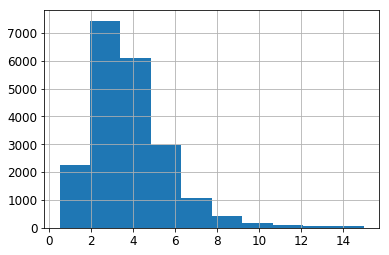

In [15]:
housing["median_income"].hist()

#### 중간 소득 카테고리화
* 중간 소득을 1.5로 나누고(소득의 카테고리 수를 제한하기 위해),  
* `ceil()` 함수를 사용해 올림해서 소득 카테고리 특성 만들고(이산적 카테고리 만들기 위해),  
* 5보다 큰 카테고리는 5로 합친다.

In [16]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].describe()

count    20640.000000
mean         3.006686
std          1.054618
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: income_cat, dtype: float64

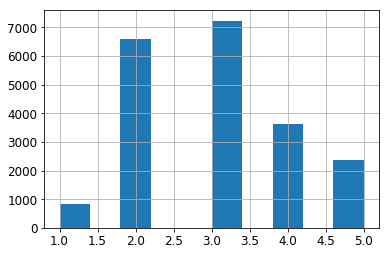

In [17]:
housing["income_cat"].hist()

In [18]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

#### 중간 소득 카테고리 기반으로 계층 샘플링하기
* 사이킷런의 `StratifiedShuffleSplit`을 사용할 수 있다.
> `StratifiedShuffleSplit` = `StratifiedKFold`의 계층 샘플링 + `ShuffleSplit`의 랜덤 샘플링
 * `test_size`, `train_size` 매개변수의 합으로 1 이하 지정도 가능하다.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
strat_train_set["income_cat"].value_counts() / len(strat_test_set)

3.0    1.402374
2.0    1.275436
4.0    0.705184
5.0    0.457607
1.0    0.159399
Name: income_cat, dtype: float64

#### 전체 데이터셋에서 계층 샘플링 전 중간 소득 카테고리의 비율

In [21]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

#### 전체 데이터셋과 계층 샘플링으로 만든 테스트 세트에서 소득 카테고리 비율 비교

In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


> 계층 샘플링을 사용해 만든 테스트 세트가 전체 데이터셋에 있는 소득 카테고리의 비율과 거의 같다.  
반면 일반 무작위 샘플링으로 만든 테스트 세트는 비율이 많이 달라졌다.

#### income_cat 특성 삭제해 데이터 원상 복구
> `drop()` : 행 또는 열을 삭제한다.
* 매개변수
    * `axis` : 0일 때는 행 삭제(default), 1일 때는 열 삭제
    * `inplace=True` : 호출된 데이터프레임 자체를 수정하고 아무런 값도 반환하지 않는다.

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) 

테스트 세트에 대해 종종 등한시되기도 하지만 머신러닝 프로젝트에서 아주 중요하다.  
게다가 이런 아이디어들은 나중에 교차 검증 이야기에 도움이 된다.

# 3. 데이터 탐색 및 시각화
* 먼저 테스트 세트를 떼어놓았는지 확인하고 훈련 세트만 탐색한다.
* 훈련 세트가 매우 크면 조작을 간단하고 빠르게 하기 위해 탐색을 위한 세트를 별도로 샘플링할 수도 있다.
* 주택 데이터셋은 크기가 작으므로 훈련 세트 전체 사용한다.
* 훈련 세트 손상을 피하기 위해 복사본 만들어 사용한다.

In [24]:
housing = strat_train_set.copy()

## 3.1. 지리적 데이터 시각화

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


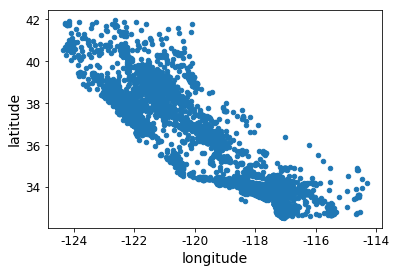

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude")

`alpha=0.1` 옵션을 주면 데이터포인트가 밀집된 영역을 잘 보여준다.

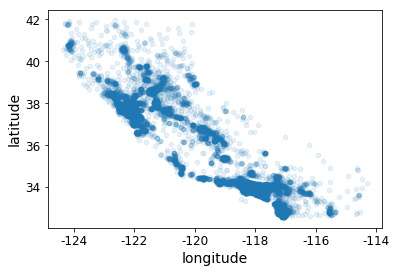

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

> 베이 에어리어(Bay Area)와 로스앤젤레스(Los Angeles) 근처, 샌디에이고(San Diego) 같이 밀집된 지역이 눈에 잘 띄고, 센트럴 밸리(Central Valley) 특히 새크라멘토(Scramento)와 프레즈노(Fresno) 근처를 따라 밀집된 지역이 긴 띠를 이루고 있음
* 캘리포이나 해변을 따라서 경도 -122˚ 근처가 샌프란시스코가 있는 베이 에어리어 지역
* 경도 -118˚ 근처가 로스앤젤레스
* 경도 -117˚ 근처가 샌디에이고 지역
* 샌트럴 밸리는 샌프란시스코 위에서부터 로스앤젤레스 위쪽까지 캘리포니아 중앙부에 길게 뻗은 지역
* 새크라멘토는 위도 38.5˚, 경도 -121.5˚ 근처
* 프레즈노는 위도 36.7˚, 경도 -119.8˚ 근처

더 두드러진 패턴을 보려면 매개변수를 다양하게 조절해봐야 한다.

#### 주택 가격 나타내기
* 원의 반지름 : 구역의 인구(매개변수 `s`)
* 색깔 : 가격(매개변수 `c`)
* 미리 정의된 컬러 맵(color map) 중 파란색(낮은 가격) ~ 빨간색(높은 가격) 범위를 가지는 jet을 사용한다.(매개변수 `cmap`)
* `sharex=False`는 x축의 값과 범례를 표시하지 못하는 버그를 수정한다.(임시 방편으로)

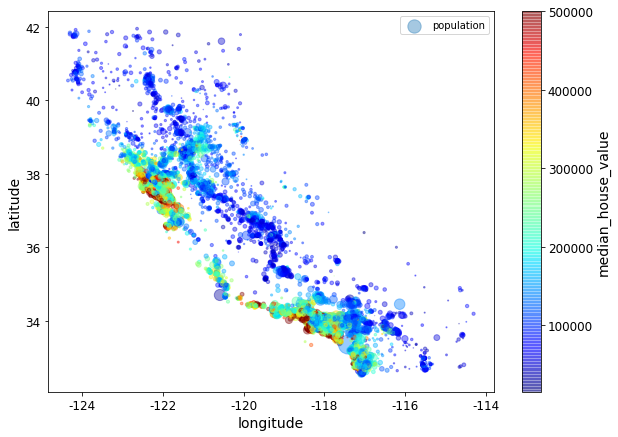

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

> 주택 가격은 지역(예. 바다와 인접한 곳)과 인구 밀도에 관련이 매우 크다.  
이런 내용은 군집 알고리즘(clustering algorithm)을 사용해 주요 군집을 찾고 군집의 중심까지의 거리를 재는 특성을 추가할 때 도움이 된다.  
해안 근접성 특성이 유용할 수도 있지만, 북부 캘리포니아 지역(대략 위도 35˚ 위쪽 지역)의 해안가는 주택 가격이 그리 높지 않아 간단한 규칙이 적용되기 어렵다.  
베이 에어리어를 제외하고는 해안가의 주택 가격이 높지 않게 나타난다.

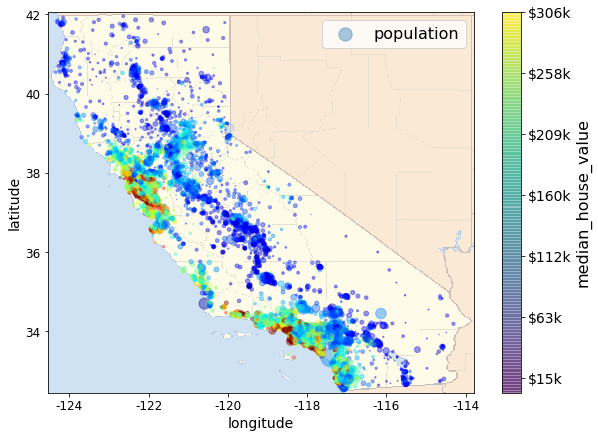

In [29]:
import matplotlib.image as mpimg


california_img = mpimg.imread('../../images\end_to_end_project\california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                 s=housing['population']/100, label="population",
                 c="median_house_value", cmap=plt.get_cmap("jet"),
                 colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("median_house_value", fontsize=16)

plt.legend(fontsize=16)
plt.show()

## 3.2. 상관관계 조사
* 데이터셋이 너무 크지 않으므로 모든 특성 간의 **표준 상관계수**(standard correlation coefficient(**피어슨 $r$**이라고도 함))를 `corr()` 메서드를 이용해 쉽게 계산할 수 있다.

In [30]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

> * median_house_value(중간 주택 가격)은 median_income(중간 소득)과 양의 상관관계가 있다.
* latitude(위도)와는 약한 음의 상관관계가 있다.
    * 북쪽으로 갈수록 주택 가격이 조금씩 내려가는 경향
    
#### 상관계수
* 상관계수는 선형적인 상관관계만 측정한다 ($x$가 증가하면 $y$는 증가/감소)  
그래서 비선형적 관계는 잡을 수 없다 (ex. $x$가 0에 가까워지면 $y$가 증가하는 경우)
* 상관계수는 기울기와도 상관없다.

#### 특성 사이의 상관관계를 확인하는 다른 방법
pandas의 `scatter_matrix()` : 숫자형 특성 사이에 산점도를 그려준다.  
여기서는 숫자형 특성이 11개 이여서 총 $11^2 = 121$개 그래프가 되어 한 페이지에 모두 나타낼 수 없다.
 
#### 중간 주택 가격과 상관관계가 높아 보이는 특성 몇 개만 살펴보기
대각선(왼쪽 위 ~ 오른쪽 아래)은 각 변수 자신에 대한 것이라 pandas는 각 특성의 히스토그램을 그린다.(default)
> `scatter_matrix()` 메서드의 `diagonal` 매개변수값 
* `kde`(커널 밀도 추정, Kernel Density Estimation)
* `hist`

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

#### 가장 유용할 것 같은 특성인 median_income(중간 소득)과의 상관관계 산점도 확대

[0, 16, 0, 550000]

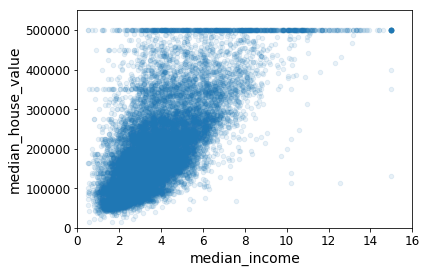

In [73]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])

> * 상관관계가 매우 강하다.  
위쪽으로 향하고 포인트들이 너무 널리 퍼져 있지 않다.
* 앞서 본 가격 제한 값이 \\$500,000에서 수평선으로 잘 보인다.
* 수평선 형태가 더 있다.
    * \\$500,000
    * \\$450,000 근처
    * \\$350,000
    * \\$280,000
    * 그 아래 부분

알고리즘이 데이터에서 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋다.

## 3.3. 특성 조합으로 실험
머신러닝 알고리즘용 데이터를 실제로 준비하기 전에 마지막으로 해볼 수 있는 것은 여러 특성의 조합을 시도해보는 것이다.
* 특정 구역의 방 개수는 얼마나 많은 가구수가 있는지 모르다면 그다지 유용하지 않다.  
진짜 필요한 것은 가구당 방 개수
*  전체 침대 개수도 그 자체로는 유용하지 않다.  
방 개수와 비교하는 게 낫다.

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
# 가구당 인원
housing["population_per_household"] = housing["population"] / housing["households"]

#### 상관관계 행렬 다시 확인하기

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

> * bedrooms_per_room 특성이 total_rooms(전체 방 개수)나 total_bedrooms(침대 개수)보다 중간 주택 가격과의 상관관계가 훨씬 높다.
* 침대/방 비율이 낮은 집은 더 비싼 경향이 있다.
* rooms_per_household(가구당 방 개수)를 보면 더 큰 집이 더 비싸다.

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", 
            alpha=0.2)
plt.axis([0, 5, 0, 520000])

In [77]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


* 이 탐색 과정은 시작을 잘해서 빨리 통찰을 얻는 것이 처음 프로토타입을 잘 만드는 데 도움이 된다.  
하지만 이는 반복적인 과정이다. 프로토타입을 만들고 실행한 후 그 결과를 분석해서 더 많은 통찰을 얻고 다시 이 탐색 단계로 돌아오게 된다.
* 대부분 SW 프로젝트가 그렇지만 특히 머신러닝 프로젝트는 빠른 프로토타이핑과 반복적인 프로세스가 권장된다.

# 4. 머신러닝 알고리즘을 위한 데이터 준비
이 작업을 수동으로 하는 대신 함수를 만들어 자동화해야 하는 이유
* 어떤 데이터셋에서도 데이터 변환을 손쉽게 반복할 수 있다.
    * ex) 다음번에 새로운 데이터셋 사용할 때
* 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
* 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는 데 이 함수를 사용할 수 있다.
* 여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는 데 편리하다.
    
먼저 원래 훈련 세트로 복원하고(`strat_train_set` 다시 한 번 복사), 예측 변수와 타깃 값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블을 분리한다.  
(`drop()`은 데이터 복사본을 만들며 `strat_train_set`에는 영향을 주지 않음)

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1) # 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

## 4.1. 데이터 정제
total_bedrooms 특성 누락된 값 수정 방법
* 해당 구역 제거
* 전체 특성 삭제
* 특정 값으로 대체(0, 중간값, 평균 등)

데이터프레임의 `dropna()`, `drop()`, `fillna()` 메서드를 이용해 간단히 처리 가능하다.

In [32]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


#### 옵션 1. 해당 구역(샘플) 제거

In [33]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


#### 옵션 2. 특성 삭제

In [34]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


#### 옵션 3. 특정 값으로 대체
이 때 계산된 중간값을 저장해야 한다.
* 나중에 시스템을 평가할 때 테스트 세트에 있는 누락된 값을 바꾸기 위해 필요하고, 시스템이 실제 운영될 때 새로운 데이터에서 누락된 값을 바꿔야 하기 때문이다.  
> 훈련 세트에서 학습한 것이 소용없어지므로 테스트 세트의 중간값을 사용하면 안 된다.

In [35]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


#### 사이킷런 `SimpleImputer`로 누락값 손쉽게 다루기
수치형 특성에만 중간값이 계산되기 때문에 텍스트 특성 ocean_proximity를 제외한 수치형 특성만 복사한다.

In [36]:
from sklearn.impute import SimpleImputer

# SimpleImputer의 객체 생성
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
# housing_num = housing.select_dtypes(include=[np.number]) # 다른 방법

total_bedrooms 특성에만 NA가 있지만 나중에 시스템이 서비스될 때 새로운 데이터에서 어떤 값이 누락될지 확신할 수 없기 때문에 모든 수치형 특성에 `imputer`를 적용해야 한다.

In [37]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

`imputer`는 각 특성의 중간값을 객체의 `statistics_` 속성에 저장한다.

In [38]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

수동으로 계산한 결과

In [39]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

#### 훈련 세트 변환
학습된 `imputer` 객체를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 대체한다.
* 변형된 특성들이 들어있는 평범한 Numpy 배열을 반환하기 때문에 Pandas 데이터프레임으로 변경해주어야 한다. 

In [40]:
X = imputer.transform(housing_num)

#### Pandas 데이터프레임으로 다시 되돌림

In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=list(housing.index.values))

In [42]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [43]:
imputer.strategy

'median'

In [44]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


> **scikit-learn 설계 철학**  
* **일관성** : 모든 객체가 일관되고 단순한 인터페이스를 공유한다.  
    * **추정기**(estimator) : 데이터셋을 기반으로 일련의 모델 파라미터들을 추정하는 객체  
    ex) `imputer` 객체는 추정기이다.
        * 추정 자체는 `fit()` 메서드에 의해 수행되고 하나의 매개변수로 하나의 데이터셋만 전달한다.
            * 지도 학습 알고리즘에서는 매개변수는 2개, 두 번째 데이터셋은 레이블을 담고 있다.
        * 추정 과정에서 필요한 다른 매개변수들은 모두 하이퍼파라미터로 간주되고(ex. `imputer` 객체의 `strategy` 매개변수), 인스턴스 변수(객체가 각각 독립적으로 가지는 변수)로 저장된다.  
        (보통 생성자의 매개변수로 전달한다. `__init()__`)
    * **변환기**(transformer) : 데이터셋을 변환하는 추정기(`imputer` 같이)
        * 변환은 데이터셋을 매개변수로 전달받은 `transform()` 메서드가 수행하고 변환된 데이터셋을 반환한다.
        * 이런 변환은 일반적으로 `imputer`의 경우와 같이 학습된 모델 파라미터(`imputer`가 실제로 계산한 것은 각 특성의 중간값. 사이킷런에서 변환기도 추정기와 인터페이스가 같기 때문에 학습한다고 표현)에 의해 결정된다.
        * 모든 변환기는 `fit()`, `transform()`을 연달아 호출하는 것과 동일한 `fit_transform()` 메서드도 가지고 있다.  
        (이따금 `fit_transform()`이 최적화되어 있어 더 빠르다.)
    * **예측기**(predictor) : 일부 추정기는 주어진 데이터셋에 대해 예측을 만들 수 있다.  
    ex) `LinearRegression` 모델
        * 어떤 나라의 1인당 GDP로 삶의 만족도 예측했을 때, 예측기의 `predict()` 메서드는 새로운 데이터셋에서 상응하는 예측값을 반환한다.
        * 또한 테스트 세트(지도 학습 알고리즘이라면 레이블도 함께)를 사용해 예측의 품질을 측정하는 `score()` 메서드를 가진다.
        * 어떤 예측기는 예측의 확신을 측정하는 메서드도 제공한다.
            * 분류 모델이 제공하는 `predict_proba()`나 `decision_function()` 메서드
* **검사 기능** : 모든 추정기의 하이퍼파라미터는 public 인스턴스 변수로 직접 접근할 수 있고(예. `imputer.strategy`), 모든 추정기의 학습된 모델 파라미터도 접미사로 밑줄을 붙여 public 인스턴스 변수로 제공된다.(예. `imputer.statistics_`)
    * 사실 파이썬은 private 인스턴스 변수가 없다.
    * 따라서 모든 인스턴스 변수는 직접 참조 가능
* **클래스 남용 방지** : 데이터셋을 별도의 클래스가 아니라 Numpy 배열이나 scipy sparse(희소) 행렬로 표현한다.
    * 하이퍼파라미터는 보통 파이썬 문자열이나 숫자이다.
* **조합성** : 기존의 구성요소를 최대한 재사용한다.
    * ex) 여러 변환기를 연결한 다음 마지막에 추정기 하나를 배치한 Pipeline 추정기를 쉽게 만들 수 있다.
* **합리적인 기본값** : 사이킷런은 일단 돌아가는 기본 시스템을 빠르게 만들 수 있도록 대부분의 매개변수에 합리적인 기본값을 지정해두었다.

## 4.2. 텍스트와 범주형 특성 다루기
* 대부분의 머신러닝 알고리즘은 숫자형을 다루기 때문에 텍스트라 중간값을 계산할 수 없었던 ocean_proximity 카테고리를 숫자로 바꾼다.

In [65]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

pandas.core.series.Series

#### 카테고리를 정수값으로 변환
각 카테고리를 다른 정숫값으로 매핑해주는 Pandas의 `factorize()`를 사용한다.

In [64]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [67]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

> **이 표현 방식의 문제**  
머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각한다.  
실제로는 그렇지 않다.  
ex) 카테고리 0과 1보다 카테고리 0과 4가 더 비슷하다.

#### 해결법
일반적으로 카테고리별 이진 특성을 만들어 해결하는 방법
* 사이킷런의 `OneHotEncoder`를 이용해 범주형 값을 원-핫 벡터로 변경한다.
* **원-핫 인코딩**(one-hot encoding) : 한 특성만 1이고(핫) 나머지는 0
    * 각 행은 1이 하나, 열은 카테고리 수

> 사이킷런 0.20 버전에서 OneHotEncoder의 동작 방식이 변경되었다.  
종전에는 0 ~ 최댓값 사이의 정수를 카테고리로 인식했지만,  
앞으로는 정수나 문자열에 
상관없이 고유한 값만을 카테고리로 인식
* 경고 메세지를 피하기 위해 categories 매개변수를 auto로 설정

### 4.2.1. 원-핫 인코딩 방법 1; `OneHotEncoder` 사용하기 (입력 - 정수형 배열 형태)

In [49]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # 정수형
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> * `fit_transform()` 메서드는 2차원 배열을 넣어줘야 하는데 `housing_cat_encoded`는 1차원 배열이므로 구조를 바꿔야 한다.
* Numpy의 `reshape()` 함수에서 `-1`은 차원을 지정하지 않는다는 뜻  
    * 해당 차원의 크기는 전체 배열에서 다른 차원이 정해지고 남은 크기가 된다.
* 또한 출력을 보면 Numpy 배열이 아니고 SciPy 희소 행렬(sprse matrix)이다.
    * `OneHotEncoder`는 기본적으로 인코딩은 원-핫 벡터이고 희소 행렬을 반환한다.  
    이는 수천 개의 카테고리가 있는 범주형 특성일 경우 매우 효율적이다.  
    0을 모두 메모리에 저장하는 것은 낭비이므로 희소 행렬은 0이 아닌 원소의 위치만 저장한다.

#### 밀집 배열로 변환
이 행렬을 거의 일반적인 2차원 배열처럼 사용할 수 있지만(SciPy의 `csr_matrix`), (밀집된) Numpy 배열로 바꾸려면 `toarray()` 메서드를 호출하면 된다.

In [50]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### 4.2.2. 원-핫 인코딩 방법 2; `pd.get_dummies()` 사용하기 (입력 - 데이터프레임, 시리즈, 배열 형태)
`housing`이 Pandas 데이터프레임이므로 `pd.get_dummies(housing)`처럼 텍스트 특성을 원-핫 벡터로 간단하게 변환할 수 있다.
* `get_dummies()` : 데이터프레임에서 텍스트 특성을 가진 열을 찾아 자동으로
 원-핫 인코딩을 적용하고 반환된 데이터프레임을 반환한다.

### 4.2.3.  원-핫 인코딩 방법 3; `OneHotEncoder` 사용하기 (입력 - 문자열형 배열 형태)
`OneHotEncoder`로 문자열로 된 범주형 변수도 변환할 수 있다.

In [51]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(categories='auto')
housing_cat_reshaped = housing_cat.values.reshape(-1, 1) # 범주형
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

#### 밀집 배열로 변환

In [52]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### 인코딩 시 밀집 행렬 바로 얻기
`sparse=False`로 설정하여 희소 행렬 대신 밀집 행렬을 얻을 수 있다.

In [53]:
cat_encoder = OneHotEncoder(categories='auto', sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### 카테고리 리스트

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

카테고리 수가 많다면 원-핫 인코딩은 많은 수의 입력 특성을 만들어 훈련을 느리게 하고 성능을 감소시킬 수 있다.

#### 해결 방법
* 임베딩(embedding)이라는 조금 더 조밀한 표현을 사용할 수 있다.
    * 신경망에 대한 이해가 필요하다.

### 4.2.4. 원-핫 인코딩 방법 4; `OrdinalEncoder` 사용하기 (입력 - 정수형/문자열형 배열 형태, 데이터프레임도 받는 듯?)
> 사이킷런 0.20에 추가된 `OrdinalEncoder` 클래스는 입력 특성(레이블 $y$가 아니라 $\mathbf X$)을 위해 설계되었고 파이프라인과 잘 작동되기 때문에 더 좋은 방법이다.

In [69]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [70]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [71]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 4.3. 나만의 변환기
* 사이킷런 기능과 매끄럽게 연동하여 나만의 변환기를 만들고 싶다면, 사이킷런은 (상속이 아닌)덕 타이핑(duck typing)을 지원하므로 `fit()`(`self`를 반환), `transform()`, `fit_transform()` 메서드를 구현한 파이썬 클래스를 만들면 된다.
> 덕 타이핑 : 상속이나 인터페이스 구현이 아닌 객체의 속성이나 메서드가 객체의 유형을 결정하는 식을 말한다.

* `fit_transform()` 메소드는 `TransformerMixin`을 상속하면 자동으로 생성된다.
> 파이썬에서 이름에 Mixin이 있으면 객체의 기능을 확장하려는 목적으로 만들어진 클래스를 나타낸다.
 * `TransformerMixin`은 `fit_transform()` 메서드 하나를 가지고 있으며 이를 상속하는 모든 파이썬 클래스에 이 메서드를 제공한다.
 * `fit_transform()` 메소드는 단순히 `fit()`과 `transform()`을 메서드 연결(method chaining) 한 것이다.

* `BaseEstimator`를 상속하면(그리고 생성자에 `*args`나 `**kargs`를 사용하지 않으면) 하이퍼파라미터 튜닝에 필요한 두 메서드 `get_params()`, `set_params()`를 추가로 얻게 된다.
> * `get_params()`, `set_params()` 함수는 사이킷런의 파이프라인과 그리드 탐색에 꼭 필요한 메서드이므로 모든 추정기와 변환기는 `BaseEstimator`를 상속해야 한다.
 * 두 메서드는 생성자에 명시된 매개변수만을 참조하므로 `*args`, `**kargs`는 사용할 수 없다.
 
#### 앞서 본 조합 특성을 추가하는 간단한 변환기

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args나 **kargs가 아님
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # 더 할 일이 없음
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
                         
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

> 이 경우 변환기가 `add_bedrooms_per_room` 하이퍼파라미터 하나를 가지고 있고 기본값을 `True`로 지정한다(합리적인 기본값을 주는 것이 좋다.)
* 이 특성을 추가하는 것이 머신러닝 알고리즘에 도움이 될지 안 될지 이 하이퍼파라미터로 쉽게 확인해볼 수 있다.
* 일반적으로 100% 확신이 없는 모든 데이터 준비 단계에 대해 하이퍼파라미터를 추가할 수 있다.
* 이런 데이터 준비 단계를 자동화할수록 더 많은 조합을 자동으로 시도해볼 수 있고 최상의 조합을 찾을 가능성을 매우 높여주고 시간도 많이 절약된다.

In [76]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## 4.4. 특성 스케일링
* 트리 기반 알고리즘 몇 가지를 빼고는 나머지 머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않는다.
* 현재 데이터셋의 전체 방 개수 범위는 6 ~ 39,320인 반면 중간 소득의 범위는 0 ~ 15까지이다.
* 타깃 값에 대한 스케일링은 일반적으로 불필요하다.

#### 모든 특성의 범위를 같도록 만들어 주는 널리 쓰이는 방법
1. **min-max 스케일링**(많은 사람들이 **정규화**(normalization)라고 부른다.)
    * 0 ~ 1 범위에 들도록 값을 이동하고 스케일을 조정한다.
    * $\frac{관측값(데이터) - 최솟값}{최댓값 - 최솟값}$
    * scikit-learn에는 이에 해당하는 `MinMaxScaler` 변환기를 제공
    * 0 ~ 1 범위를 원하지 않으면 `feature_range` 매개변수로 변경 가능
> **정규화**
 * scikit-learn에는 입력 데이터에서 각 행의 l_2 노름이 1이 되도록 조정하는 `Normalizer`라는 전처리 기능이 있다.
 * min-max 스케일링과는 전혀 다른 결과를 만든다.
 * 정규화는 여러 의미로 다양하게 사용된다.

2. **표준화**(standardization)
    * 평균을 뺀 후(그래서 표준화를 하면 0이 됨), 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다.
    * min-max 스케일링과 달리 범위의 상한, 하한이 없어 어떤 알고리즘에서는 문제가 될 수 있다.
        * ex) 신경망은 종종 입력값의 범위로 0 ~ 1를 기대한다.
    * 이상치에 영향을 덜 받는다.
        * 중간 소득을 잘못해서 100이라 입력한 구역에 대해 min-max 스케일링은 0 ~ 15 값을 이상치의 영향을 받아 0 ~ 0.15로 매우 작게 만들 수 있다.
    * scikit-learn에는 표준화를 위한 `StandardScaler` 변환기가 있다.

> **CAUTION**  
모든 변환기에서 스케일링은 전체 데이터가 아닌 훈련 데이터에 대해서만 `fit()` 메서드를 적용해야 한다.  
그런 다음 훈련 세트와 테스트 세트(그리고 새로운 데이터)에 대해 `transform()` 메서드를 사용한다.

## 4.5. 변환 파이프라인
* scikit-learn은 연속된 변환을 순서대로 처리할 수 있도록 도와주는 `Pipeline` 클래스가 있다.

#### 숫자 특성을 처리하는 간단한 파이프라인

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                       ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

#### `Pipeline` 클래스
* `Pipeline`은 연속된 단계를 나타내는 이름/추정치 쌍의 목록을 입력으로 받는다.
* 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있다.  
그 외에는 모두 변환기여야 한다.(즉, `fit_transform()` 메서드를 가지고 있어야 한다. `fit()`과 `transform()` 메서드만 가지고 있어도 됨)
* 이름은 이중 밑줄 문자(__)는 포함하지 않아야 한다.

#### 파이프라인의 `fit()` 메서드 호출 시
* 모든 변환기의 `fit_transform()` 메서드(또는 `fit()`과 `transform()`)를 순서대로 호출하면서 한 단계의 출력을 다음 단계의 입력으로 전달한다.
* 마지막 단계에서는 `fit()` 메서드만 호출한다.

#### `Pipeline` 객체
* 파이프라인 객체는 마지막 추정기와 동일한 메서드를 제공한다.
* 예에서는 마지막 추정기가 변환기 `StandardScaler`이므로 `transform()` 메서드(파이프라인이 데이터에 대해 모든 변환을 순서대로 적용한다)를 가지고 있다.  
또한 `fit_transform()` 메서드도 가지고 있다.

### 4.5.1. 컬럼 추출기 만들어 파이프라인 만들기
* 데이터프레임에서 수치형/범주형 컬럼과 같은 특정 컬럼을 선택하는 클래스를 만들어 본다. 
* 기존에는 사이킷런이 데이터프레임을 다룰 수 없어 데이터프레임을 입력으로 받아 특정 컬럼을 Numpy 배열로 바꾸는 변환기를 만들어 사용한 듯하다.
> pip3 install sklearn-pandas 명령으로 비슷한 목적을 가진 `DataFrameMapper`를 얻을 수도 있다.

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

> `DataFrameSelector`는 나머지는 버리고 필요한 특성을 선택하여 데이터프레임을 Numpy 배열로 바꾸는 식으로 데이터를 변환한다.  
이를 이용해 데이터프레임을 받아 수치형만 다루는 파이프라인을 손쉽게 만들 수 있다.

#### 수치형과 범주형 특성을 각각 전처리하는 파이프라인

In [80]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(categories='auto', sparse=False))
])

#### 숫자형과 범주형 특성을 모두 다루는 전체 파이프 라인
scikit-learn의 `FeatureUnion`을 이용하여 두 파이프라인을 합칠 수 있다.  
변환기 목록(또는 모두 변환기로 이뤄진 파이프라인)을 전달하고 `transform()` 메서드를 호출하면 각 변환기의 `transform()` 메서드를 병렬로 실행한다.  
그런 다음 각 변환기의 결과를 합쳐 반환한다.
(물론 `fit()` 메서드를 호출하면 각 변환기의 `fit()` 메서드를 실행한다.)

In [83]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
     ("num_pipeline", num_pipeline),
     ("cat_pipeline", cat_pipeline),
])

### 4.5.2. `ColumnTransformer`를 이용한 간단한 파이프라인 만들기
사이킷런 0.20에 추가된 `ColumnTransformer`로 간단하게 `full_pipeline` 만들기
> `ColumnTransformer`를 사용하면 `DataFrameSelector`와 `FeatureUnion`을 사용하지 않아도 된다.

In [84]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num_pipeline", num_pipeline, num_attribs),
    ("cat_encoder", OneHotEncoder(categories='auto'), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [85]:
housing_prepared.shape

(16512, 16)

# 5. 모델 선택과 훈련
## 5.1. 훈련 세트에서 훈련하고 평가하기

#### 선형 회귀 모델 훈련

In [86]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### 훈련 세트의 몇 개 샘플에 대해 적용해보기

In [87]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측: ", lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels))

예측:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


> 아주 정확한 예측은 아니지만(첫 번째 예측은 40% 가까이 벗어남) 작동은 한다.

#### RMSE 측정
scikit-learn의 `mean_square_error()` 함수 이용해 전체 훈련 세트에 대한 이 회귀 모델의 RMSE 측정

In [88]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

> 없는 것보다는 낫지만 좋은 점수는 아니다.  
대부분 구역의 중간 주택 가격은 \\$120,000 \~ \\$265,000인데, 예측 오차가 \\$68,628은 매우 만족스럽지 못하다.  
* 이는 모델이 훈련 데이터에 과소적합된 사례  
즉 특성들이 좋은 예측을 만들만큼 충분한 정보를 제공하지 못했거나, 모델이 충분히 강력하지 못한 것

#### 과소적합 해결법
1. 더 강력한 모델 선택
2. 훈련 알고리즘에 더 좋은 특성 주입
3. 모델의 규제 감소시키기  
(이 모델은 규제를 사용하지 않았으므로 이 옵션 제외)

#### 평균 절대 편차(MAE)

In [89]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

### 5.1.1. 특성 추가(예. 로그 스케일된 인구) 전 먼저 더 복잡한 모델 시도해보기

#### DecisionTreeRegressor 훈련시키기
해당 모델은 강력하고 데이터에서 복잡한 비선형 관계를 찾을 수 있다.

In [91]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
# 모델 훈련
tree_reg.fit(housing_prepared, housing_labels)
# 훈련 세트로 평가
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

> 오차가 없다는 것은 모델이 완벽하다는 뜻  
이는 데이터에 너무 심하게 과대적합된 것

확신이 드는 모델이 론칭할 준비가 되기 전까지 테스트 세트를 사용하지 않으려 하므로 훈련 세트의 일부분으로 훈련을 하고 다른 일부분은 모델 검증에 사용해야 한다.

## 5.2. 교차 검증을 사용한 평가

#### 모델 평가 방법 생각해보기
1. `train_test_split()` 함수로 훈련 세트를 더 작은 훈련 세트와 검증 세트로 나누고 더 작은 훈련 세트에서 모델을 훈련시키고 검증 세트로 모델을 평가하는 방법
    * 조금 수고스럽지만 너무 어렵지 않으며 매우 잘 작동한다.
2. scikit-learnn의 **교차 검증** 기능 사용하는 방법
    * 훌륭한 대안
    * **K-겹 교차 검증**(k-fold cross-validation)
        1. 훈련 세트를 **폴드**(fold)라 불리는 K개의 서브셋으로 무작위 분할한다.
        2. 모델을 K번 훈련하고 평가한다.
            * 매번 다른 폴드를 선택해 평가에 사용하고, 나머지 K-1개 폴드는 훈련에 사용한다.  
        3. K개의 평가 점수가 담긴 배열이 결과가 된다.
        
#### 결정 트리 10겹 교차 검증(k-fold cross-validation)으로 평가하기

In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

> **CAUTION**
* 사이킷런의 교차 검증 기능은 scoring 매개변수에 (낮을수록 좋은)비용 함수가 아니라 (클수록 좋은)효용 함수를 기대한다.
    * 그래서 평균 제곱 오차(MSE)의 반댓값(즉, 음수값)을 계산하는 `neg_mean_squared_error` 함수를 사용한다.
    * 이런 이유로 제곱근 계산 전 `-scores`로 부호 변경
    >> * MSE가 작을수록 좋은 비용 함수이므로 부호가 반대가 되어야 `scoring` 매개변수 정의에 맞는다.
     * 회귀 모델에서 `scoring` 매개변수를 지정하지 않으면 기본적으로 0 ~ 1 값을 가지는 `r2_score`가 사용된다.
     
#### 교차 검증 결과

In [93]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


> * 결정 트리 결과가 이전만큼 좋지 않다.  
실제로 선형 회귀 모델보다 나쁘다.
* 교차 검증으로 모델 성능 추정 외 이 추정이 얼마나 정확한지(즉, 표준편차) 측정할 수 있다.
    * 결정 트리 점수가 대략 평균 71,407에서 ±2,439 사이
* 검증 세트를 하나만 사용했다면 이런 정보를 얻지 못한다.  
하지만 모델을 여러 번 훈련시켜야 해서 비용이 비싸므로 교차 검증을 언제나 쓸 수 있는 것은 아니다.

#### 비교를 위해 선형 회귀 모델의 교차 검증 점수 계산

In [95]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


> 확실히 결정 트리 모델이 과대적합되어 선형 회귀 모델보다 성능이 나쁘다.

#### 교차 검증 결과 좀 더 편하게 보기

In [97]:
pd.Series(lin_rmse_scores).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

#### `RandomForestRegressor` 모델 교차 검증해보기
* **랜덤 포레스트** : 특성을 무작위로 선택해서 많은 결정 트리를 만들고 그 예측을 평균내는 방식의 앙상블 기법
* **앙상블 학습** : 여러 다른 모델을 모아서 하나의 모델을 만드는 것
    * 머신러닝 알고리즘의 성능을 극대화하는 방법 중 하나

In [99]:
from sklearn.ensemble import RandomForestRegressor

# 경고 메세지를 피하기 위해 n_estimator 10으로 설정
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [100]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


> 훨씬 좋다.  
하지만 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮음으로 과대적합

#### 과대적합 해결방법
1. 모델을 간단히 하는 것
2. 제한하는 것(즉, 규제)
3. 더 많은 훈련 데이터 모으는 것

특정 모델을 더 깊이 들어가기 전에 여러 종류의 머신러닝 알고리즘으로 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서, 다양한 모델(다양한 커널의 SVM, 신경망 등)을 시도해봐야 한다.  
가능성 있는 2 ~ 5개 정도의 모델을 선정하는 것이 목적이다.

> **TIP**  
실험한 모델을 모두 저장해두면 필요할 때 쉽게 모델을 복원할 수 있다.
* 교차 검증 점수, 실제 예측값, 하이퍼파라미터, 훈련된 모델 파라미터 모두 저장해야 한다.  
이렇게 하면 여러 모델의 점수와 모델이 만든 오차를 쉽게 비교할 수 있다.
* 파이썬의 `pickle` 패키지나 `sklearn.externals.joblib`(넘파이 배열을 저장하는 데 아주 효율적)을 사용하여 사이킷런 모델을 간단히 저장할 수 있다.

In [ ]:
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")
# 그리고 나중에...
my_model_loaded = joblib.load("my_model.pkl")

# 6. 모델 세부 튜닝
가능성 있는 모델들을 추렸다면 이 모델들의 세부 튜닝을 해야한다.  
가장 단순한 방법은 만족할 만한 하이퍼파라미터 조합을 찾을 때까지 수동으로 하이퍼파라미터를 조정하는 것이다.
이는 매우 지루하고 시간이 비효율이다.

## 6.1. 그리드 탐색
scikit-learn의 `GridSearchCV`를 사용한 탐색
* 탐색하고자 하는 하이퍼파라미터와 시도해볼 값을 지정하기만 하면 된다.
* 그러면 가능한 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용해 평가한다.

#### 랜덤 포레스트에 대한 최적의 하이퍼파라미터 조합 탐색

In [101]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 하이퍼파라미터 12(3*4=12)개 조합을 시도한다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6개 조합을 시도한다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor(random_state=42)

# 5 폴드에서 훈련하면 90((12+6)*5)번 훈련이 일어난다.
grid_search = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error',
                           cv=5, return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

> * `param_grid` 설정에 따라 scikit-learn이 먼저 첫 번째 dict에 있는 `n_estimators`와 `max_features` 하이퍼파라미터의 조합인 3 * 4 = 12개를 평가하고, 그런 다음 두 번째 dict에 있는 하이퍼파라미터 조합인 2 * 3= 6개를 시도한다.
    * 이 때는 `bootstrap` 하이퍼파라미터를 `True`(기본값)가 아니라 `False`로 설정한다.
* 모두 합하면 그리드 탐색이 `RandomForestRegressor` 하이퍼파라미터 값의 12 + 6 = 18개 조합을 탐색하고, 각각 다섯 번 모델을 훈련시킨다.  
즉 전체 훈련 횟수 : 18 * 5 = 90

> **TIP**  
어떤 하이퍼파라미터 값을 지정해야 할지 모를 때는 연속된 10의 거듭제곱 수로 시도해보는 것도 좋다.
* 더 세밀하게 탐색하려면 위 예제의 `n_estimators` 하이퍼파라미터처럼 더 작은 값을 지정한다.

#### 최적의 하이퍼파라미터 값
이는 시간이 꽤 오래 걸리지만 다음과 같이 최적의 조합을 얻을 수 있다.

In [102]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

> **TIP**  
8과 30은 탐색 범위의 최댓값이기 때문에 계속 점수가 향상될 가능성이 있어 더 큰 값으로 다시 검색해야 한다.

#### 최적의 추정기
최적의 추정기에 직접 접근할 수도 있다.

In [104]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

> **NOTE**  
`GridSearchCV`가 `refit=True`(default)로 초기화되었다면 교차 검증으로 최적의 추정기를 찾은 다음 전체 훈련 세트로 다시 훈련시킨다.  
일반적으로 데이터가 많을수록 성능이 향상되므로 좋은 방법이다.

#### 조합별 평가 점수 확인
조합별로 평가 점수도 확인할 수 있다.

In [105]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

> `max_features: 8, n_estimators: 30` 일 때, RMSE 점수가 49,682로 기본 하이퍼파라미터 설정으로 얻은 점수보다 조금 더 좋다.

In [106]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068943,0.006750,0.003672,0.000243,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.248694,0.056802,0.011606,0.003679,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.645925,0.018875,0.026768,0.000536,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.108031,0.004123,0.003176,0.000243,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.342745,0.006895,0.010318,0.000783,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07


> **TIP**  
* 데이터 준비 단계를 하나의 하이퍼파라미터처럼 다룰 수 있다.
    * ex) 그리드 탐색이 확실하지 않은 특성을 추가할지 말지 자동으로 정할 수 있다.
        * ex) `CombinedAttributesAdder` 변환기의 `add_bedrooms_per_room` 하이퍼파라미터를 사용하여 특성을 추가할지 결정한다.
* 비슷하게 이상치나 값이 빈 특성을 다루거나 특성 선택 등을 자동으로 처리하는 데 그리드 탐색을 사용한다.
>> * 데이터 준비 단계와 모델을 연결한 파이프라인을 그리드 탐색에 적용할 때 데이터 준비 단계를 캐싱하면 탐색 시간을 줄일 수 있다.  
    https://goo.gl/cq9Nyb


그리드 탐색 방법은 비교적 적은 수의 조합을 탐구할 때 괜찮다.  
하지만 하이퍼파라미터 탐색 공간이 커지면 `RandomizedSearchCV`를 사용하는 편이 더 좋다.
> 특히 규제처럼 설정값이 연속형인 경우 랜덤 탐색이 권장된다.
* 랜덤 탐색을 10회 반복하여 찾은 최적의 하이퍼파라미터는 `n_esimators: 180, max_features: 7`이다.

## 6.2. 랜덤 탐색
`RandomizedSearchCV`는 `GridSearchCV`와 거의 같은 방식이지만 가능한 모든 조합을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가한다.

#### 이 방식의 주요 장점
* 랜덤 탐색을 1,000회 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1,000개의 값을 탐색한다.
    * 그리드 탐색은 하이퍼파라미터마다 몇 개의 값만 탐색한다.
* 단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원을 제어할 수 있다.

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error',
                               random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


## 6.3. 앙상블 방법
* 모델을 세밀하게 튜닝하는 또 다른 방법은 최상의 모델을 연결해보는 것이다.
* 모델의 그룹(또는 앙상블, ensemble)이 최상의 단일 모델보다 더 나은 성능을 발휘할 때가 많다.
    * ex) 결정 트리의 앙상블인 랜덤 포레스트
    * 특히 개개의 모델이 각기 다른 형태의 오차를 만들 때
* 7장 참고
    
## 6.4. 최상의 모델과 오차 분석
최상의 모델을 분석하면 문제에 대한 좋은 통찰을 얻는 경우가 많다.  
ex)  
`RandomForestRegressor`가 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려준다.

In [108]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

#### 중요도와 그에 대응하는 특성 이름 표시
사이킷런 0.20 버전의 `ColumnTransformer`를 사용했기 때문에 `full_pipline`에서 `cat_encoder`를 가져온다.  
즉 `cat_pipline`을 사용하지 않는다.

In [109]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_encoder = full_pipeline.named_transformers_["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

> 이 정보를 바탕으로 덜 중요한 특성을 제외할 수 있다.  
ex)  
ocean_proximity 카테고리 중 하나만 실제로 유용하므로 다른 카테고리는 제외할 수 있다.

시스템이 특정한 오차를 만들었다면 왜 그런 문제가 생겼는지 이해하고 문제를 해결하는 방법을 찾아야 한다.
* 추가 특성을 포함시키거나, 반대로 불필요한 특성을 제거하거나, 이상치를 제외하는 등

## 6.5. 테스트 세트로 시스템 평가하기
어느 정도 모델을 튜닝하면 마침내 만족할 만한 모델을 얻는다.  
그럼 이제 테스트 세트로 최종 모델을 평가할 차례이다.  
이 과정에 특별히 다른 점은 없다.  
테스트 세트에서 예측 변수와 레이블을 얻은 후 `full_pipeline`을 사용해 데이터를 변환하고(`fit_transform()`이 아니라 `transform()`을 호출해야 한다!) 테스트 세트에서 최종 모델을 평가한다.

In [111]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47730.22690385927

> * 하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통이다.
    * 우리 시스템이 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에 새로운 데이터셋에는 잘 작동하지 않을 가능성이 크다.
* 이 예제에서는 성능이 낮아지진 않았지만, 이런 경우가 생기더라도 테스트 세트에서 성능 수치를 좋게 하려고 하이퍼파라미터 튜닝 시도를 해서는 안된다.  
그렇게 향상된 성능은 새로운 데이터에 일반화되기 어렵다.

#### 테스트 RMSE에 대한 95% 신뢰 구간 계산

In [112]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1, loc=np.mean(squared_errors),
                        scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

#### 신뢰 구간 수동 계산

In [113]:
tscore = stats.t.ppf((1 + confidence)/2, df=m-1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

#### z점수 계산

In [114]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

이제 프로젝트 론칭 직전 단계에 왔다.  
솔루션(학습한 것, 한 일과 하지 않은 일, 수립한 가정, 시스템 제한사항 등을 강조하면서)과 문서를 출시하고, 깔끔한 도표와 기억하기 쉬운 제목으로(예. 수입의 중간값이 주택 가격 예측의 가장 중요한 지표다.') 멋진 발표 자료를 만들어야 한다.

# 7. 론칭, 모니터링, 그리고 시스템 유지 보수

#### 론칭 전 준비
솔루션 론칭 허가 받은 후 이제 제품 시스템에 적용하기 위한 준비를 해야 한다.
* 특히 입력 데이터 소스를 우리 시스템에 연결하고 테스트 코드를 작성해야 한다.
* 또한 일정 간격으로 시스템의 실시간 성능을 체크하고 성능이 떨어졌을 때 알람을 통지할 수 있는 모니터링 코드를 작성해야 한다.
    * 갑작스런 오작동뿐만 아니라 성능 감소 상황을 잡아내기 위해서도 아주 중요하다.
    * 새로운 데이터를 사용해 주기적으로 훈련시키지 않으면 데이터가 오래됨에 따라 모델도 함께 낙후되는 것이 일반적이다.
    
#### 유지보수; 시스템 성능 평가
시스템의 성능을 평가하려면 시스템의 예측을 샘플링해서 평가해야 한다.
* 일반적으로 이런 과정에는 사람의 분석이 필요
* 이런 분석가는 해당 분야의 전문가이거나 크라우드 소싱 플랫폼에서 구한 인력일 수 있다.
* 어느 쪽이든 사람의 분석 파이프라인과 시스템을 연결해야 한다.

#### 유지보수; 입력 데이터 품질 평가
시스템의 입력 데이터 품질 역시 평가해야 한다.
* 가끔 품질 낮은 시그널(예. 오작동하는 센서가 예측 불허의 값을 보낸다거나 다른 팀의 출력이 멈춰 있는 경우) 때문에 성능이 조금 감소하지만 알람이 울릴 정도로 감소되기까지 다소 시간이 걸린다.
* 시스템의 입력을 모니터링하면 이보다 일찍 알 수 있다.
* 특히 온라인 학습 시스템에서는 입력을 모니터링하는 일이 중요하다.
 
#### 유지보수; 정기적 모델 훈련
마지막으로 새로운 데이터를 사용해 정기적으로 모델을 훈련시켜야 한다.
* 가능하면 이 과정을 자동화할 것
* 그렇지 않으면 (기껏해야) 6개월마다 모델을 갱신하게 될 것이고, 시스템의 성능이 시간에 따라 심하게 출렁일 것이다.
* 온라인 학습 시스템이라면 일정 간격으로 시스템의 상태를 스냅샷으로 저장해서 이전 상태로 쉽게 되돌릴 수 있도록 해야한다.

# 추가 내용
## p.s. 1. 전처리와 예측을 포함한 파이프라인

In [116]:
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("linear", LinearRegression())
])
full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## p.s. 2. `joblib`을 사용한 모델 저장

In [119]:
my_model = full_pipeline_with_predictor

In [120]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## p.s. 3 RandomizedSearchCV을 위한 Scipy 분포 함수

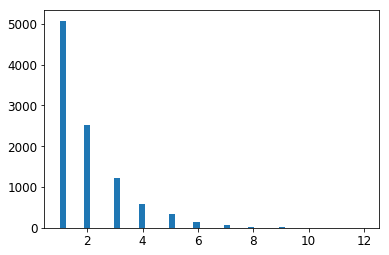

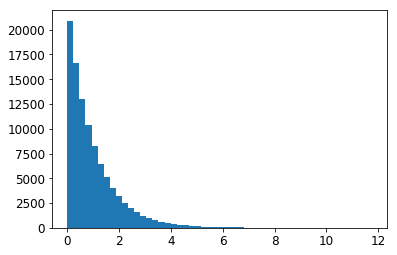

In [117]:
from scipy.stats import geom, expon

geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(100000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# 연습 문제
이 장에서 소개한 주택 가격 데이터셋을 사용해 문제를 푸세요.

## 1.
서포트 벡터 머신 회귀(`sklear.svm.SVR`)를 `kernel="linear"`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel="rbf"`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

## 2.
`GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

## 3.
가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

## 4.
전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어 보세요.

## 5.
`GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.